# EDA for W261 Criteo Display Advertising Challenge

First, get things set up.

In [ ]:
%%bash
pip install missingno

In [206]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sb
import matplotlib.pyplot as plt
import missingno as msno
plt.style.use('ggplot')

In [47]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "hw4_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

__`REMINDER:`__ If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

## Loading Data
Subset the data and load some of it into memory.

In [14]:
# shuf is a linux commands that gets a random permutation of the lines of a file
!shuf -n 100000 data/train.txt > data/sample.txt

In [25]:
rawRDD = spark.read.csv("data/sample.txt", header=False, sep="\t").rdd

In [27]:
dataRDD = rawRDD.map(lambda row: ([None if el is None else int(el) for el in row[1:14]] + list(row[14:]), int(row[0])))

In [180]:
sample = dataRDD.takeSample(withReplacement=False, num=10000)

numeric_columns = np.array([pair[0][:13] for pair in sample], dtype=np.float)
category_columns = np.array([pair[0][13:] for pair in sample])
labels = np.array([pair[1] for pair in sample])

## Analyze 13 Numeric Columns

First, see how many values are missing.

In [182]:
# get percentage of NaN values for each column
for i in numeric_df:
    print(i, ": ", np.mean(np.isnan(numeric_df[i])))

0 :  0.4533
1 :  0.0
2 :  0.2156
3 :  0.2198
4 :  0.0266
5 :  0.2238
6 :  0.0467
7 :  0.0007
8 :  0.0467
9 :  0.4533
10 :  0.0467
11 :  0.7648
12 :  0.2198


Let's also visualize that. This will help to see if the missing values are correlated. Gray means not missing and white means missing.

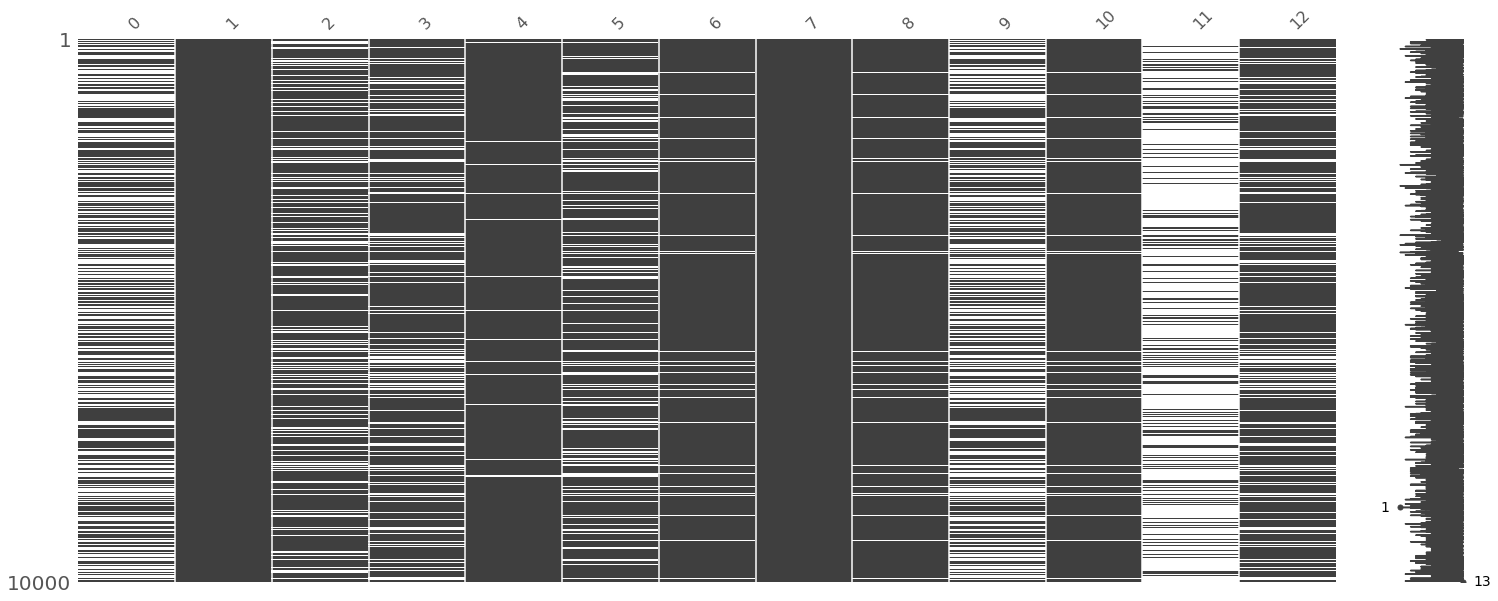

In [186]:
# plot positions of missing values
msno.matrix(numeric_df);

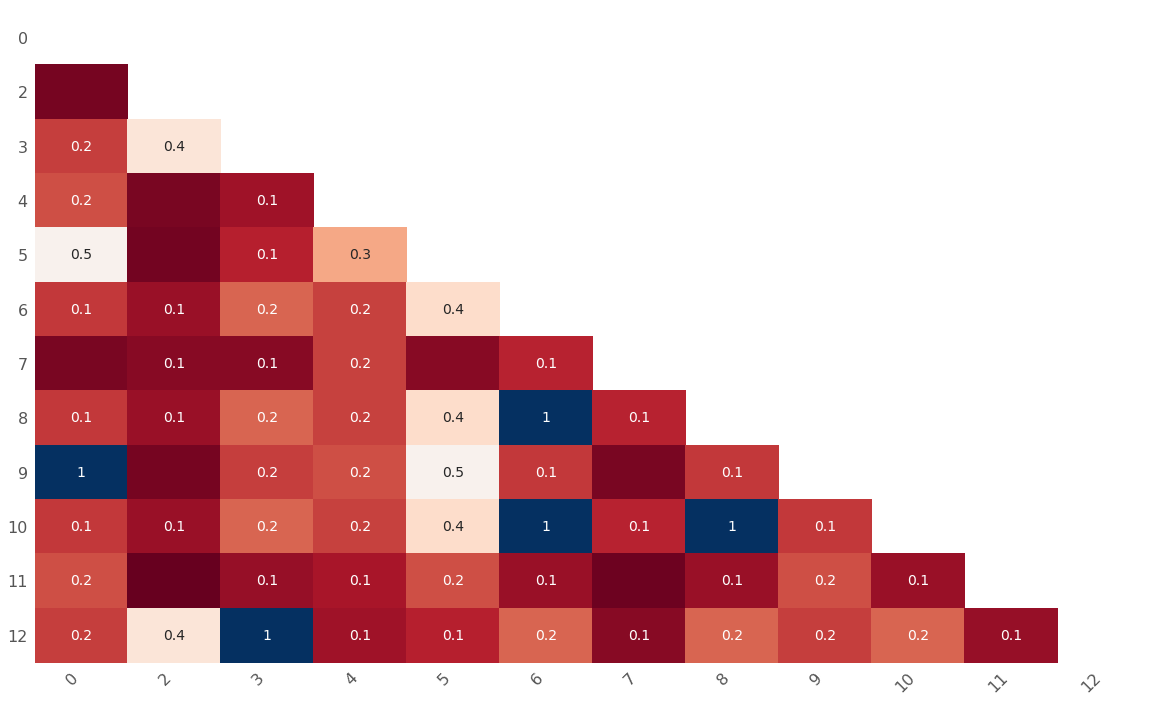

In [193]:
# explicit heatmap showing how correlated the missing values are. for example, this shows that whenever column 9 is `null`, column 0 is always `null` too
msno.heatmap(numeric_df);

Next, look at the spread of the values which are present, such as histograms.

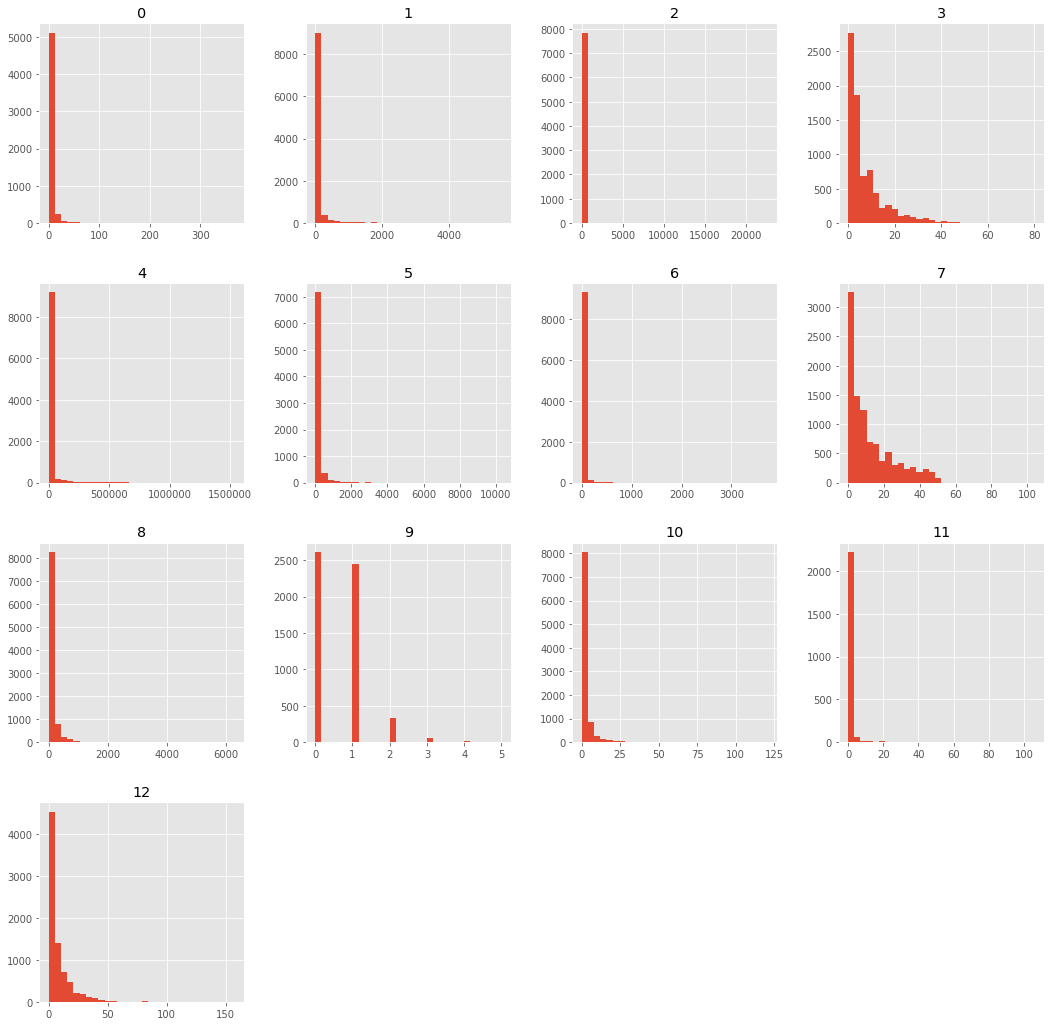

In [181]:
numeric_df = pd.DataFrame(numeric_columns)
numeric_df.hist(figsize=(18, 18), bins=30);

These are all very skewed. Let's also look at a log-transform (and add constant value to avoid issues with 0's).

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


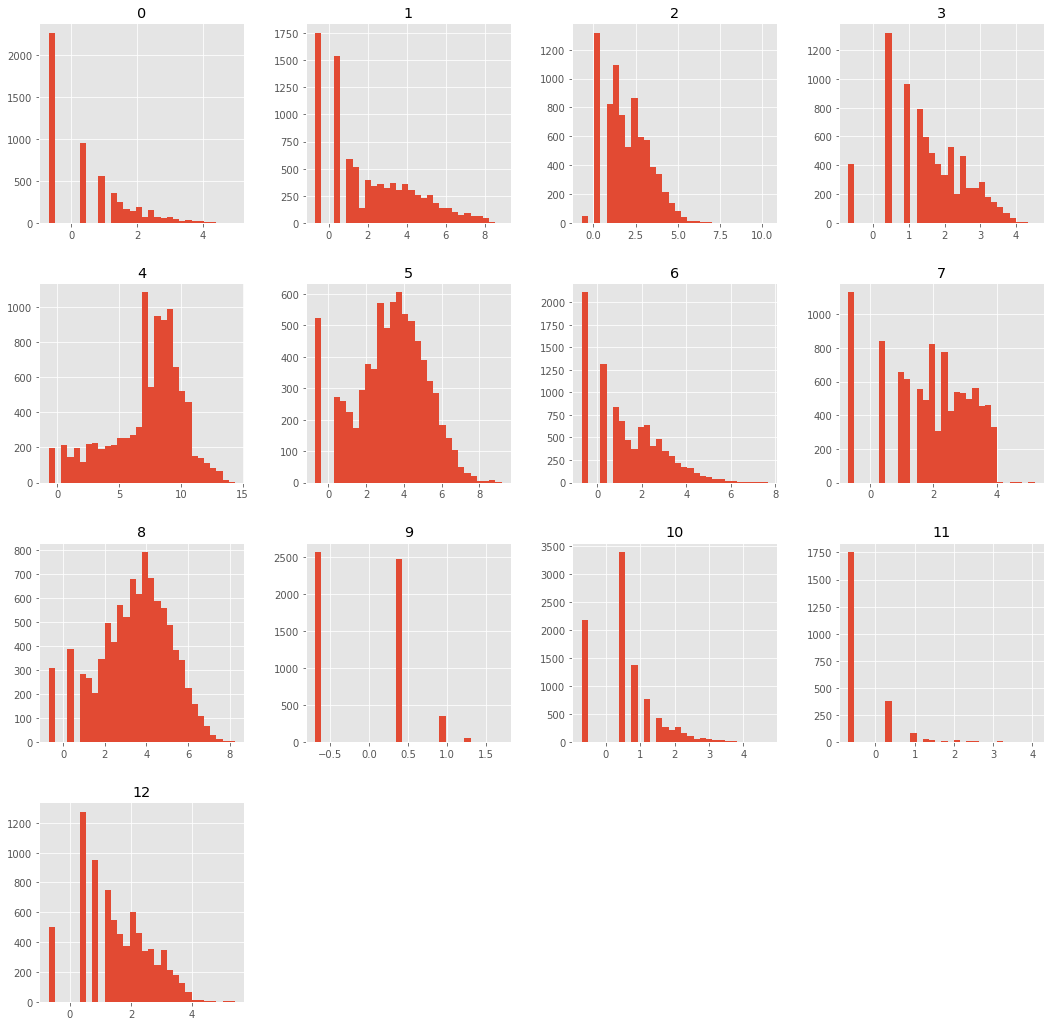

In [132]:
np.log(numeric_df + 0.5).hist(figsize=(18, 18), bins=30);

Whoa there are some negative values. Weird!

In [109]:
numeric_df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,5456.0,3.601723,8.450465,0.0,0.00,1.0,3.00,147.0
1,10000.0,104.449700,384.307716,-2.0,0.00,3.0,35.25,7123.0
2,7858.0,30.679053,488.274098,0.0,2.00,6.0,18.00,30864.0
3,7823.0,7.480251,8.846027,0.0,2.00,4.0,10.00,91.0
4,9744.0,19192.729885,72611.570857,0.0,334.75,2797.0,10154.50,1764388.0
5,7788.0,116.864022,341.768097,0.0,8.00,31.0,99.00,9646.0
6,9545.0,16.839811,68.150380,0.0,1.00,3.0,11.00,2155.0
7,9998.0,12.373875,13.157621,0.0,2.00,7.0,19.00,179.0
8,9545.0,103.616867,204.710858,0.0,10.00,37.0,107.00,3899.0
9,5456.0,0.621518,0.672006,0.0,0.00,1.0,1.00,5.0


Now break down the distributions of values per-label. See if anything correlates strongly with the target. Not really. The spreads look similar.

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


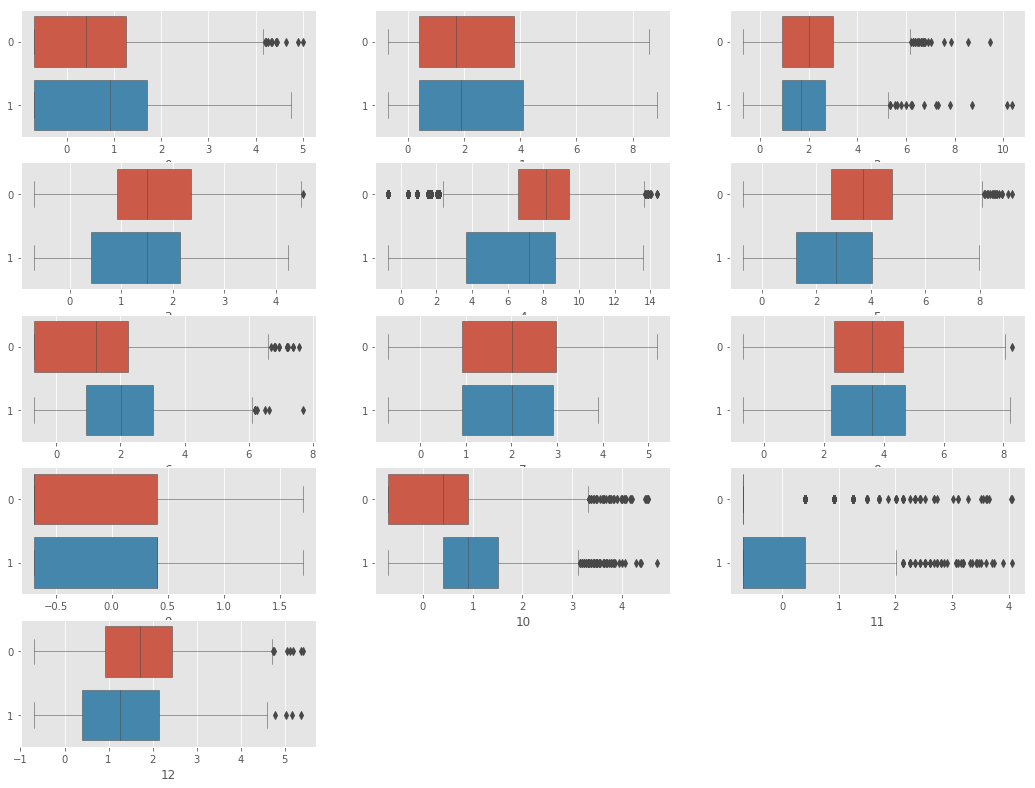

In [126]:
plt.figure(figsize=(18, 36))
for i in numeric_df:
    x = numeric_df[i]
    plt.subplot(len(numeric_df.columns), 3, i + 1)
    sb.boxplot(np.log(x + 0.5), labels, orient='h', linewidth=0.5)

plt.show()

Are the features correlated with each other? Only a few.

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


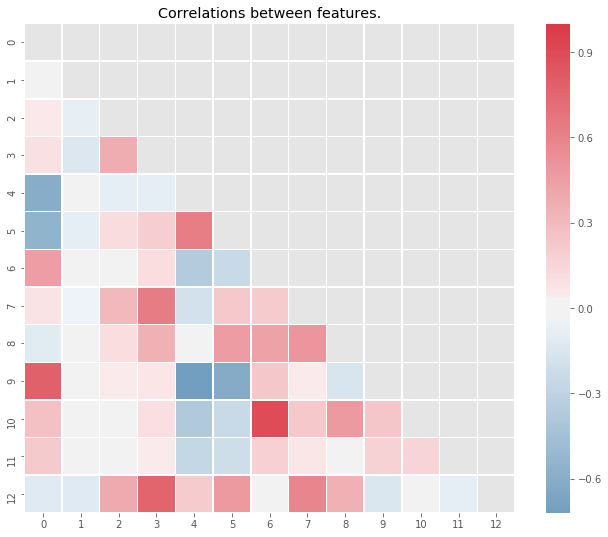

In [131]:
# plot heatmap for correlations matrix - RUN THIS CELL AS IS
corr = np.log(numeric_df + 0.5).corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sb.diverging_palette(240, 10, as_cmap=True)
sb.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

In [ ]:
# this isn't actually very informative, so nevermind
#scatter_matrix(np.log(numeric_df + 0.5), figsize=(18, 18));

## Analyze 26 Categorical Columns

Again, start by analyzing for missing values.

In [178]:
# get percent of missing values for each column

for i in category_df:
    print(i, ": ", np.mean(category_df[i].isna()))

0 :  0.0
1 :  0.0
2 :  0.035
3 :  0.035
4 :  0.0
5 :  0.1208
6 :  0.0
7 :  0.0
8 :  0.0
9 :  0.0
10 :  0.0
11 :  0.035
12 :  0.0
13 :  0.0
14 :  0.0
15 :  0.035
16 :  0.0
17 :  0.0
18 :  0.4414
19 :  0.4414
20 :  0.035
21 :  0.7634
22 :  0.0
23 :  0.035
24 :  0.4414
25 :  0.4414


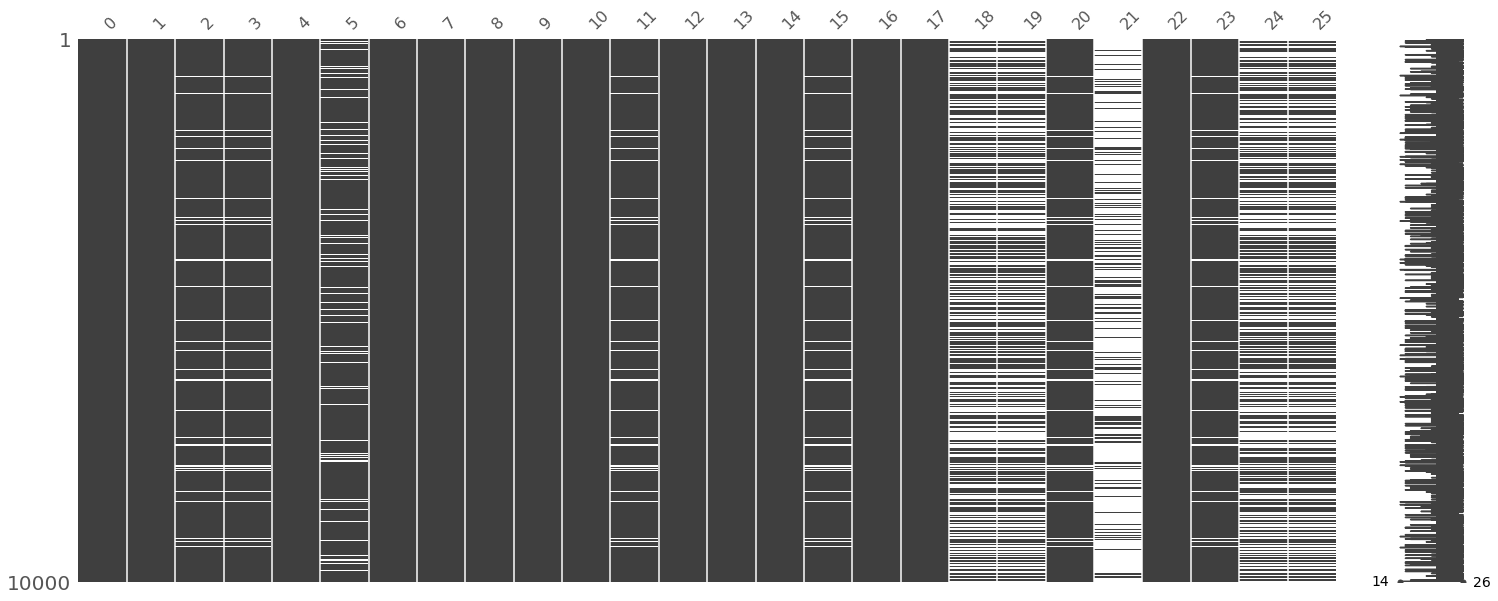

In [185]:
# plot positions of missing values
msno.matrix(category_df);

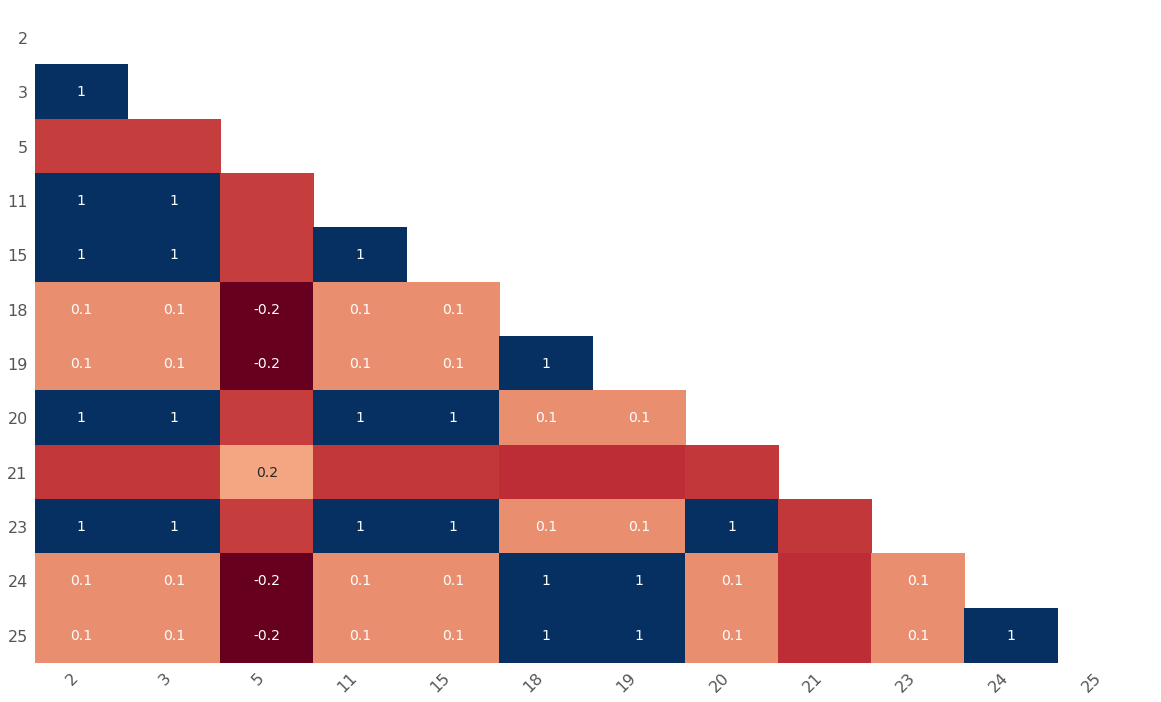

In [194]:
msno.heatmap(category_df)

The missing values are clearly correlated! Most of these look good, but some have mostly missing values. Next, we see that many of these columns don't really have a small group of categories. Instead, there are a large number of rare catergories! What a mess!

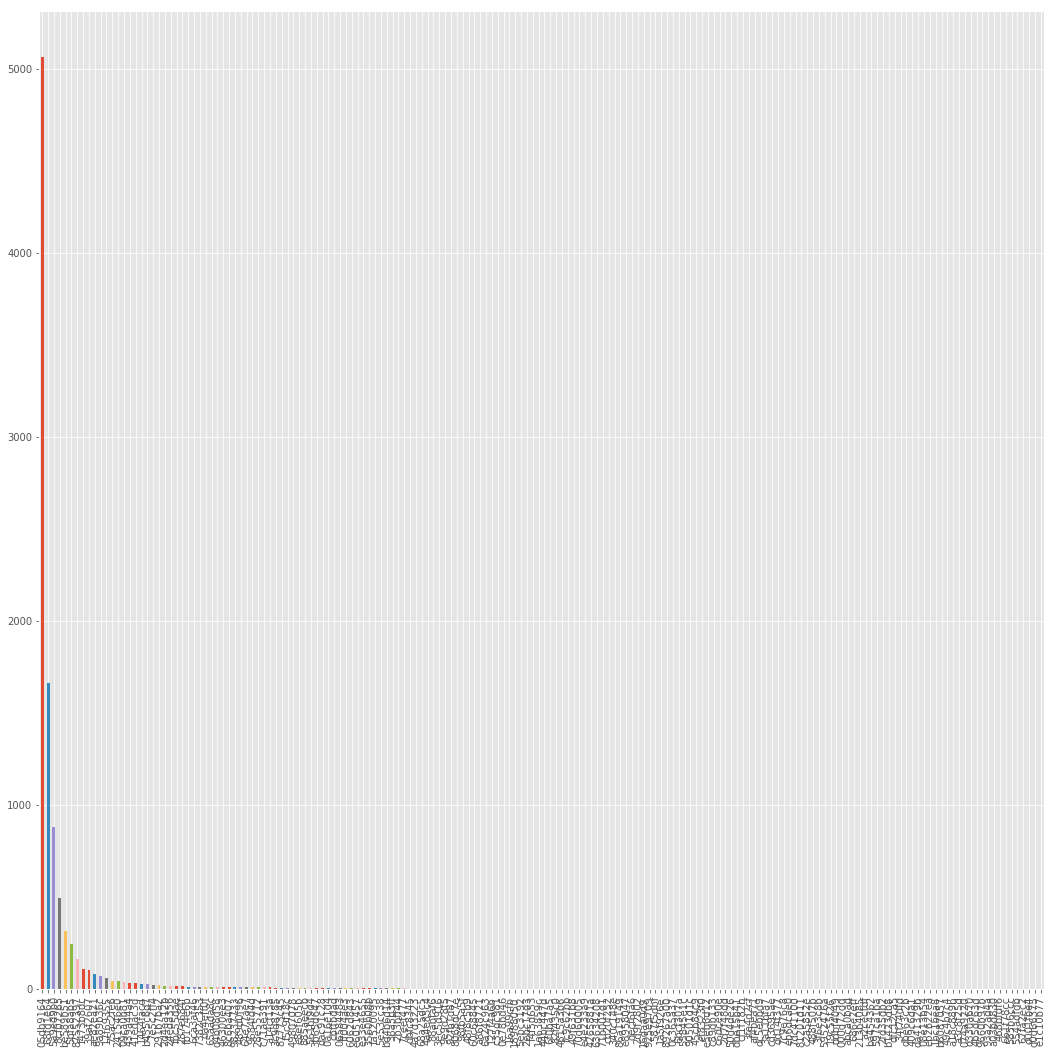

In [162]:
# plot counts for all the possible values of the first column. there are too many categories that appear only once!
category_df = pd.DataFrame(category_columns)
counts = pd.value_counts(category_df[0]).plot(kind="bar", figsize=(18, 18))

In [163]:
category_df.describe().T

,count,unique,top,freq
0,10000,172,05db9164,5062
1,10000,396,38a947a1,1149
2,9650,6001,d032c263,252
3,9650,4284,c18be181,346
4,10000,60,25c83c98,6768
5,8792,8,7e0ccccf,3973
6,10000,3358,1c86e0eb,201
7,10000,95,0b153874,5850
8,10000,3,a73ee510,8999
9,10000,3301,3b08e48b,2210


Next, plot histograms for the counts. This shows how widespread this rare-category problem is.

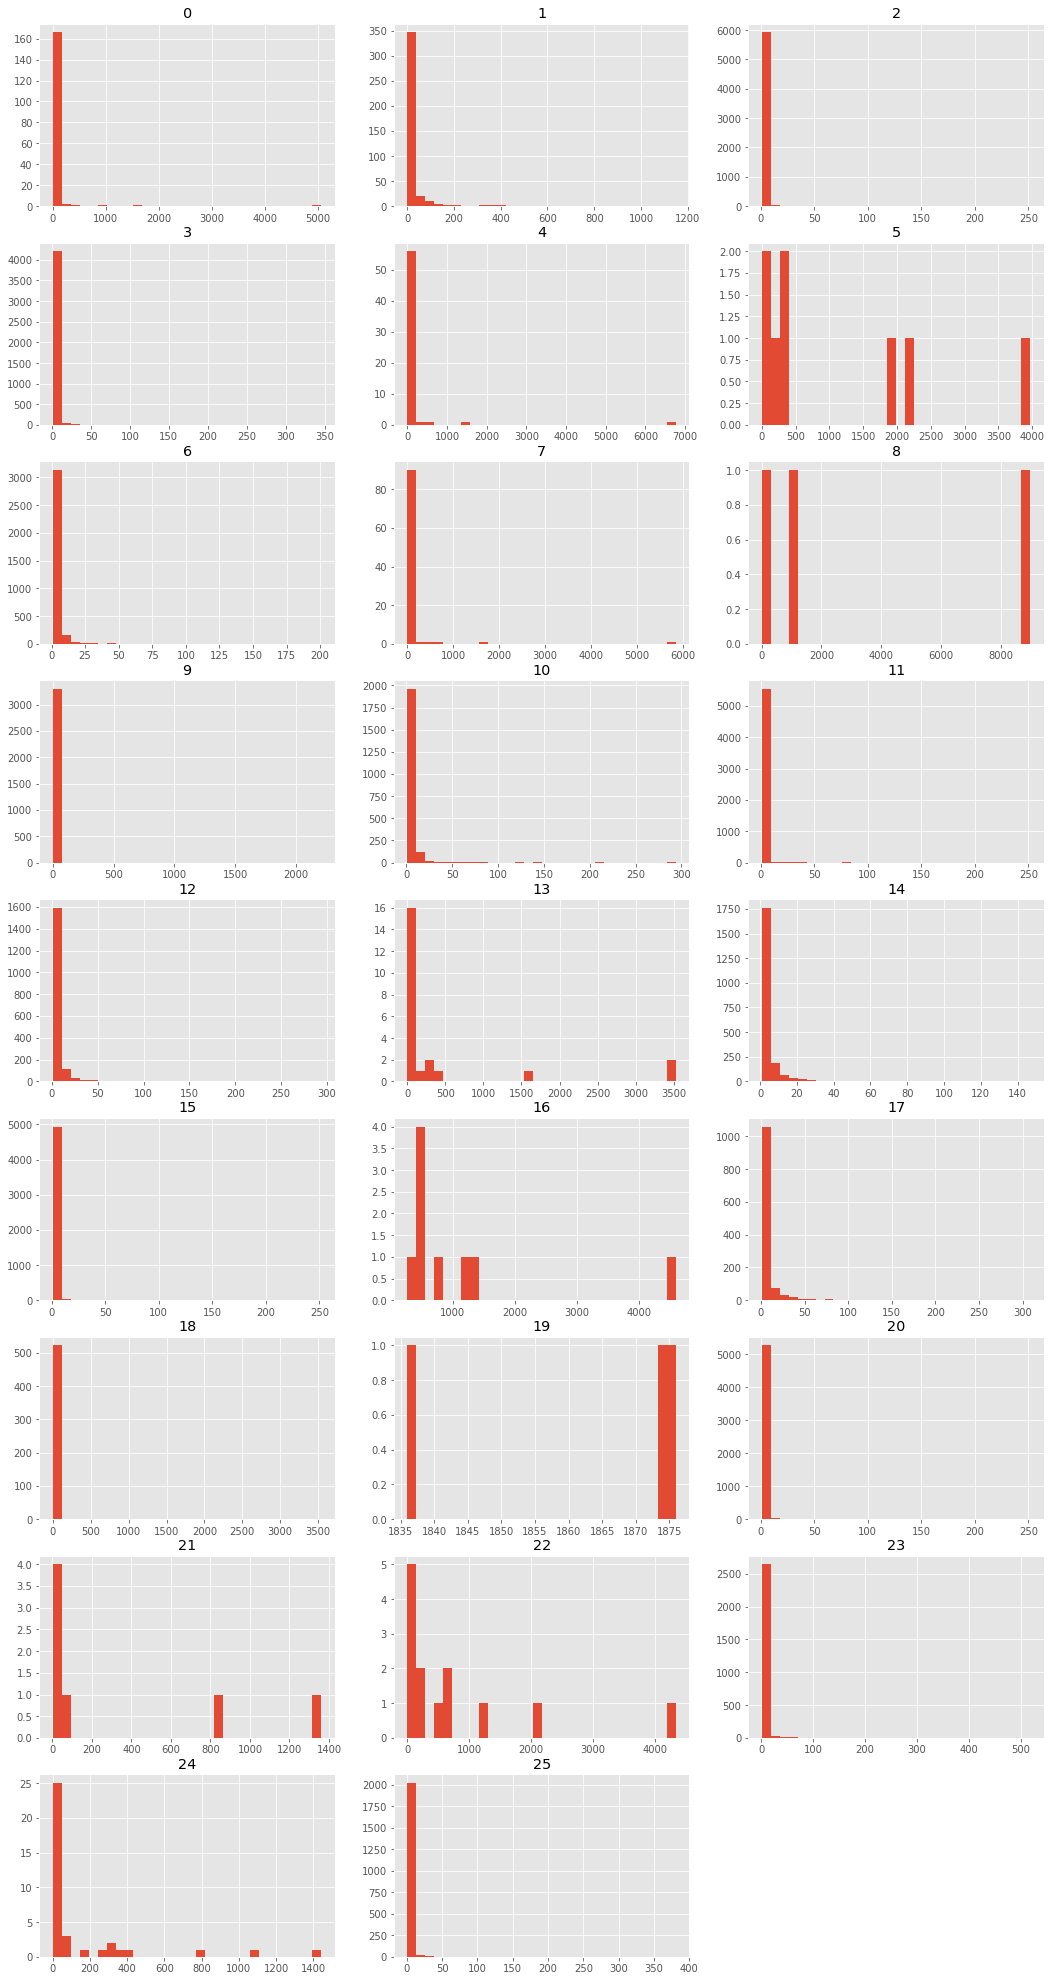

In [164]:
plt.figure(figsize=(18, 4 * len(category_df.columns)))
for i in category_df:
    counts = pd.value_counts(category_df[i])
    plt.subplot(len(category_df.columns), 3, i + 1)
    plt.hist(counts.values, bins=30)
    plt.title(i)

## Analyze Labels

About 3/4 of the labels are 0s.

In [113]:
np.mean(labels)

0.2566